# Readme

The purpose of this notebook is to test setting up a LISA simulation pipeline using __LISA Instrument__.

If simulating noise within __LISA Instrument__, this will only be good for shorter test simulations.  Otherwise all noise sources can be turned off, and LISA Instrument can be used for multi-year simulations.

$\longrightarrow$ __NOTE__: If all noise sources are turned off, then running LISA Instrument is not necessary - orbit and GW Response files can be passed directly to PyTDI.


$\left.\begin{matrix}
\text{Orbits}\quad\\ 
\text{GW Response}\quad
\end{matrix}\right\} \quad \text{PyTDI}$


# Setup

In [1]:
import numpy as np
import scipy.signal
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy import constants as const, units as u
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig

# Constants
from lisaconstants import c
# Orbits
from lisaorbits import EqualArmlengthOrbits, KeplerianOrbits
from datetime import datetime
# GWResponse
from lisagwresponse import ReadStrain
# Instrument
from lisainstrument import Instrument
# PyTDI
from pytdi.michelson import X1 #, Y1, Z1, X2, Y2, Z2
from pytdi import Data

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist, log_uniform
from eryn.utils import PeriodicContainer
from eryn.moves import tempering   # useful to print out the temperature ladder
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.state import State
from eryn.backends import HDFBackend

In [2]:
def discretePSD_1s(x_1s_dft, timingarray, norm):
    """
    Calculate the discrete **1-SIDED** PSD of a times series.  The discrete definition approaches the analytic
    solution in the limit that the number of data points N --> infty (i.e., Delta t --> 0)

    Inputs:
     - x_1s_dft:    1-sided DFT of a time series (array)
     - timingarray: timing data (array)
     - norm:        the normalization convention that was used to generate the input DFT
                    {“backward”, “ortho”, “forward”}

    Return:
     - PSD: the discrete 1-sided PSD of a time series (array)
    """
    
    N  = timingarray.size
    dt = timingarray[1] - timingarray[0]    
    T  = timingarray[-1] - timingarray[0]
    
    if norm == 'backward':
        G = 1
    if norm == 'forward':
        G = 1/N
    if norm == 'ortho':
        G = 1/np.sqrt(N)
    
    return 2 * dt**2 / T / G**2 * np.abs( x_1s_dft * np.conj(x_1s_dft) )

## Orbits

Run these cells if you need to generate the orbit file for the first time.  If the desired orbit file already exists, then we can skip this section and just load the orbit file in the later sections.

__NOTE__: The most accurate orbit file created so far by the collaboration is the `esa-orbits.h5`.  

In [3]:
# number of timing data points
orbit_time_samples = 100

# Starting time
orbit_time = datetime.fromisoformat('2037-01-01 00:00:00')
print("Orbit time = ", orbit_time.timestamp())

# NOTE: it's good practice that the orbit file is a little bit longer than the simulation length
orbits = KeplerianOrbits(size = orbit_time_samples,
                         t0   = orbit_time)

Orbit time =  2114398800.0


In [4]:
print("Orbit sampling frequency = {0:0.1e} Hz".format(orbits.fs))
print("Orbit dt                 = {0:0.1f} days  = {1:0.1e} sec".format(orbits.dt * u.s.to(u.day), orbits.dt))
print("Orbit duration           = {0:0.1f} years = {1:0.1e} sec".format(orbits.duration * u.s.to(u.year), orbits.duration))
print("Orbit sample size        =", orbits.size)

Orbit sampling frequency = 1.0e-05 Hz
Orbit dt                 = 1.2 days  = 1.0e+05 sec
Orbit duration           = 0.3 years = 1.0e+07 sec
Orbit sample size        = 100


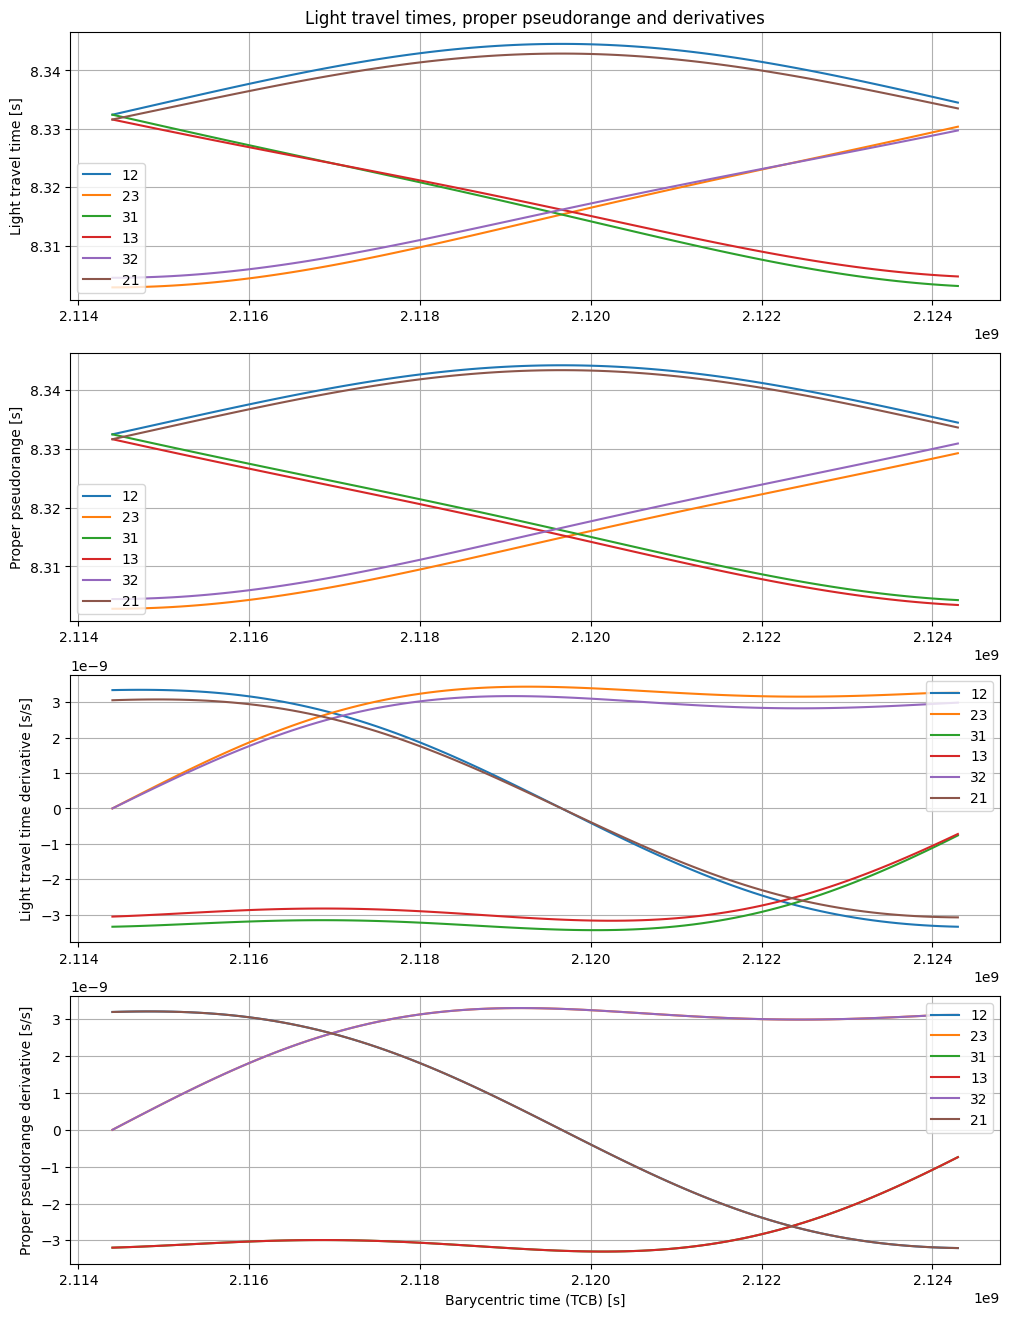

In [5]:
orbits.plot_links()

In [6]:
!rm ./orbits_keplerian.h5

orbits.write('./orbits_keplerian.h5')

## GW Response  

In [7]:
# Load the desired orbit file
orbit_file = './orbits_keplerian.h5'

with h5py.File(orbit_file) as f:
    orbit_t0 = f.attrs['t0']
    orbit_dt = f.attrs['dt']
    orbit_fs = f.attrs['fs']
    orbit_duration = f.attrs['duration']
    orbit_size     = f.attrs['size']

print("Start time of the orbit = ", orbit_t0)

Start time of the orbit =  2114398800.0


In [8]:
def SineGaussian(A, f0, phi0, sigma, t0, t):

    S = A*np.cos(phi0 + 2*np.pi*f0*(t - t0))
    G = np.exp(- (t - t0)**2 / (2*sigma**2))
    
    return S*G

In [9]:
def SineGaussian_FT(A, f0, phi0, sigma, t0, freqs_1s):
    
    return A/2 * np.sqrt(2*np.pi*sigma**2) * np.exp(-1j*2*np.pi*freqs_1s*t0) * ( np.exp(1j*phi0 - 2*np.pi**2*sigma**2*(freqs_1s-f0)**2) + np.exp(-1j*phi0 - 2*np.pi**2*sigma**2*(freqs_1s+f0)**2) )


In [10]:
fs = 0.2
dt = 1/fs

starttime = orbit_t0 + 100
endtime   = starttime + 2*u.day.to(u.s)

times = np.arange(starttime, endtime, dt)

times.shape

(34560,)

In [11]:
A     = 1e-21
f0    = 0.001
phi0  = 1.7
sigma = 100
t0    = starttime + 30562

gw_beta   = np.pi/4
gw_lambda = 0

injection = [A, f0, phi0, sigma, t0, gw_lambda, gw_beta]

In [12]:
# Sample and Nyquist frequencies
fNy = fs/2

if fs <= 2*f0:
     print(' \n--> Aliasing Warning: Sample frequency <= 2 x (highest) Signal frequency\n')
print("Signal frequency   = {0:0.3f}".format(f0))
print("Nyquist frequency  = {0:0.3f}".format(fNy))

Signal frequency   = 0.001
Nyquist frequency  = 0.100


In [13]:
signal_hplus = SineGaussian(*injection[:-2], times)
signal_hcross = np.zeros(len(times))

signal_hplus.shape, signal_hcross.shape

((34560,), (34560,))

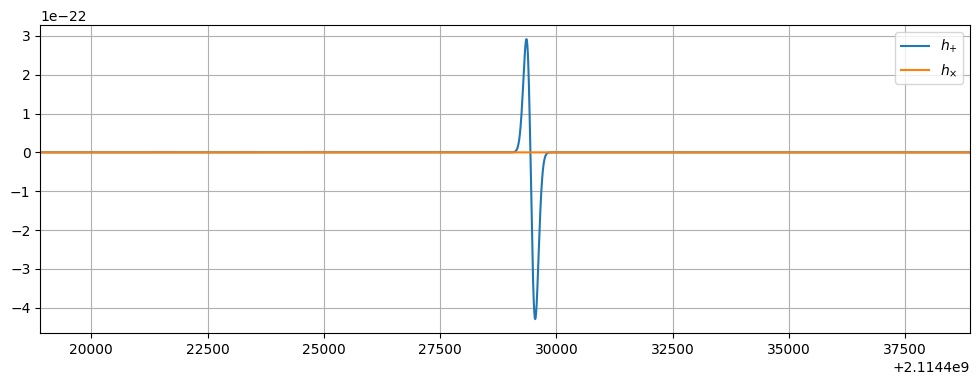

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.plot(times, signal_hplus, label=r'$h_{+}$')
ax.plot(times, signal_hcross, label=r'$h_{\times}$')

ax.set_xlim([starttime + 20000, starttime + 40000])
ax.legend()
ax.grid()
plt.show()

In [15]:
gwsource = ReadStrain(times, signal_hplus, signal_hcross,
                      orbits = orbit_file,
                      gw_beta = gw_beta,
                      gw_lambda = gw_lambda,
                      size = times.size,
                      dt = dt,
                      t0 = starttime
                     )

You are using an orbit file in a version that might not be fully supported


In [16]:
# Spline interpolation is also used to honor the requested sampling parameters; make sure that lisagwresponse.ReadStrain.t matches 
# your time array to prevent any resampling. --> https://lisa-simulation.pages.in2p3.fr/gw-response/master/read.html

np.all(gwsource.t == times)

True

In [17]:
print("Orbit sampling frequency = {0:0.1e} Hz".format(orbit_fs))
print("Orbit dt                 = {0:0.1f} days = {1:0.1e} sec".format(orbit_dt * u.s.to(u.day), orbit_dt))
print("Orbit duration           = {0:0.1f} years = {1:0.1e} sec".format(orbit_duration * u.s.to(u.year), orbit_duration))
print("Orbit sample size        =", orbit_size)

print("\nGW sampling frequency = {0:0.1e} Hz".format(gwsource.fs))
print("GW dt                 = {0:0.1f} sec".format(gwsource.dt))
print("GW duration           = {0:0.1f} days = {1:0.1e} sec".format(gwsource.duration * u.s.to(u.day), gwsource.duration))
print("GW sample size        =", gwsource.size)

Orbit sampling frequency = 1.0e-05 Hz
Orbit dt                 = 1.2 days = 1.0e+05 sec
Orbit duration           = 0.3 years = 1.0e+07 sec
Orbit sample size        = 100

GW sampling frequency = 2.0e-01 Hz
GW dt                 = 5.0 sec
GW duration           = 2.0 days = 1.7e+05 sec
GW sample size        = 34560


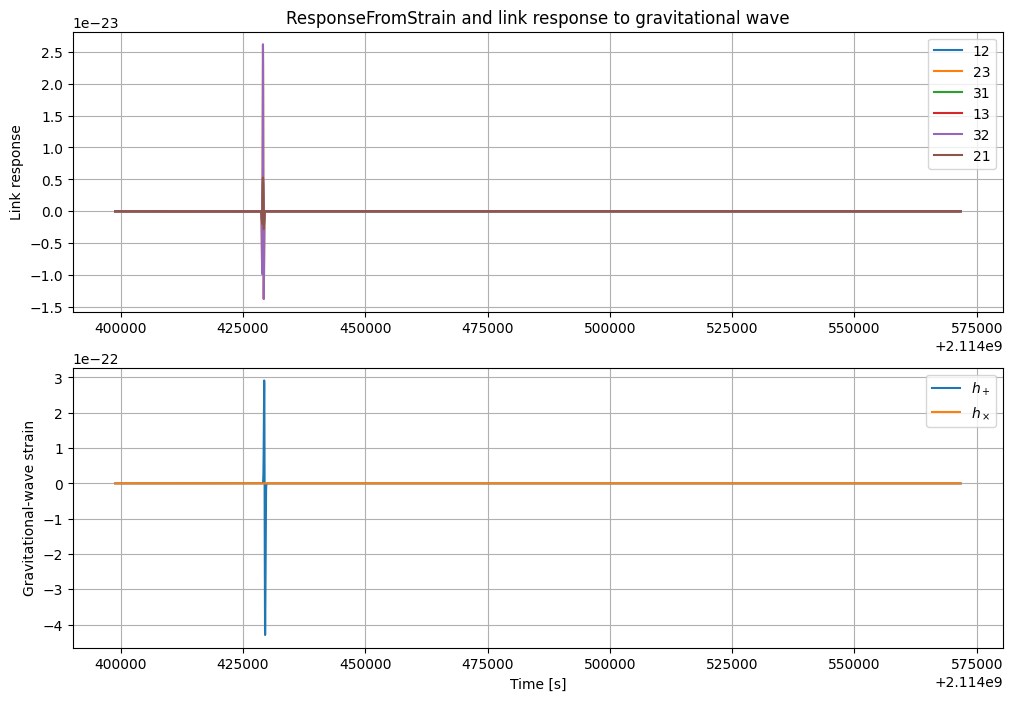

In [18]:
gwsource.plot(gwsource.t)

In [19]:
!rm ./gw.h5

gw_file = './gw.h5'

gwsource.write(path = gw_file, timeframe = 'tcb')

## PyTDI

In [20]:
# Location of PyTDI output file
tdi_file = './xtdi.h5'

In [21]:
data = Data.from_gws(gw_file, orbit_file, gw_dataset='tcb', orbit_dataset='tcb/ltt')

TDI_X = X1.build(**data.args)
central_freq = 2.816e14
X_data = TDI_X(data.measurements) / central_freq  # remember to divide it by the central frequency of the laser

In [22]:
!rm ./xtdi.h5

hf = h5py.File(tdi_file, 'w')  # <-- Use if initially creating the document

hf.create_dataset('burst', data=X_data)
hf.create_dataset('times', data=times)
hf.close()

In [23]:
np.random.seed(42)


noise_sigma = 1e-40

noise = np.random.normal(0, noise_sigma, len(times))

In [24]:
final_data = noise + X_data

In [25]:
injection

[1e-21, 0.001, 1.7, 100, 2114429462.0, 0, 0.7853981633974483]

In [26]:
# glitch_guess = [5e-38, 0.002, 1.7, 130, 2114429150.0]
# glitch_guess = [4e-25, 0.0028, 1.7, 140, 2114429150.0]
glitch_guess = [4e-40, 0.0028, 1.7, 140, 2114429150.0]

glitch_guess_data = SineGaussian(*glitch_guess, times)

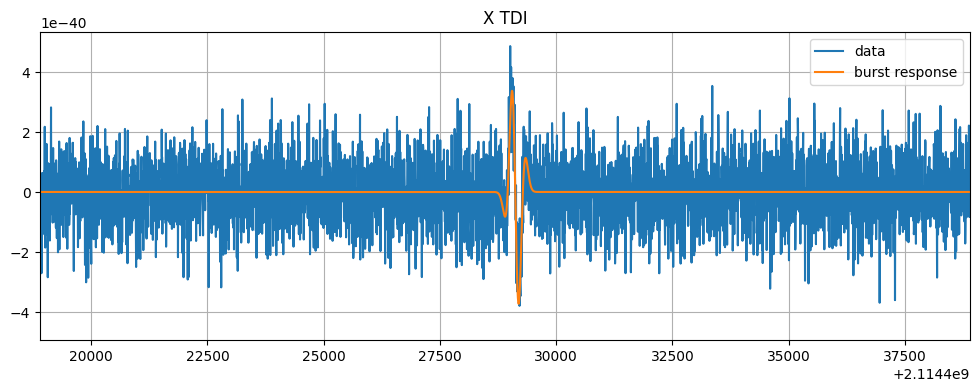

In [97]:
fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.plot(times, final_data, label='data')
ax.plot(times, X_data, label='burst response')

ax.set_title('X TDI')
ax.set_xlim([starttime+20000, starttime+40000])
ax.legend()
ax.grid()
plt.show()

In [28]:
2*np.pi*0.0028*140

2.463008640414398

In [29]:
start_trim = 100
end_trim   = -100

# Set the normalization convention
norm = "backward"

# Compute the one-dimensional discrete Fourier Transform for real input (output is still complex!)
X_DFT_1s = np.fft.rfft(X_data, norm=norm)
noise_DFT_1s = np.fft.rfft(noise, norm=norm)

Xguess_DFT_1s = np.fft.rfft(SineGaussian(*glitch_guess, times), norm=norm)  

# Return the Discrete Fourier Transform sample frequencies and their spacing
freqs_1s = np.fft.rfftfreq(times.size, dt)

df = freqs_1s[1] - freqs_1s[0]

# CUT THE FIRST f=0 FROM THE DATASET!!!
cut_first_freq = True
if cut_first_freq:
    X_DFT_1s      = X_DFT_1s[1:]
    noise_DFT_1s  = noise_DFT_1s[1:]
    Xguess_DFT_1s = Xguess_DFT_1s[1:]
    freqs_1s      = freqs_1s[1:]

print("Fourier data length =", freqs_1s.shape[0])

Fourier data length = 17280


In [30]:
# fig, ax = plt.subplots(1,1,figsize=(10,6))

# ax.plot(freqs_1s, np.real(Xguess_DFT_1s), label='DFT')
# ax.plot(freqs_1s, np.real(SineGaussian_FT(*glitch_guess, freqs_1s) / dt), '--', label='FT')

# ax.set_xlim([0,0.002])
# ax.legend()
# plt.show()

In [31]:
def Sn_1s_white(sigma, freqs_1s, dt):
    """
    Calculate the discrete **1-SIDED** PSD of white noise.  The PSD of white noise is frequency
    independent, so this function just returns an appropriately sized array of a constant value.

    Inputs:
     - sigma:       the white noise standard deviation (float)
     - freqs_1s:    the 1-sided frequency values (array)
     - dt:          timing data dt (float)

    Return:
     - PSD: the discrete 1-sided white noise PSD (array)
    """

    return 2 * sigma**2 * dt * np.ones(freqs_1s.size)

In [32]:
S_noise = Sn_1s_white(noise_sigma, freqs_1s, dt)

S_noise.shape

(17280,)

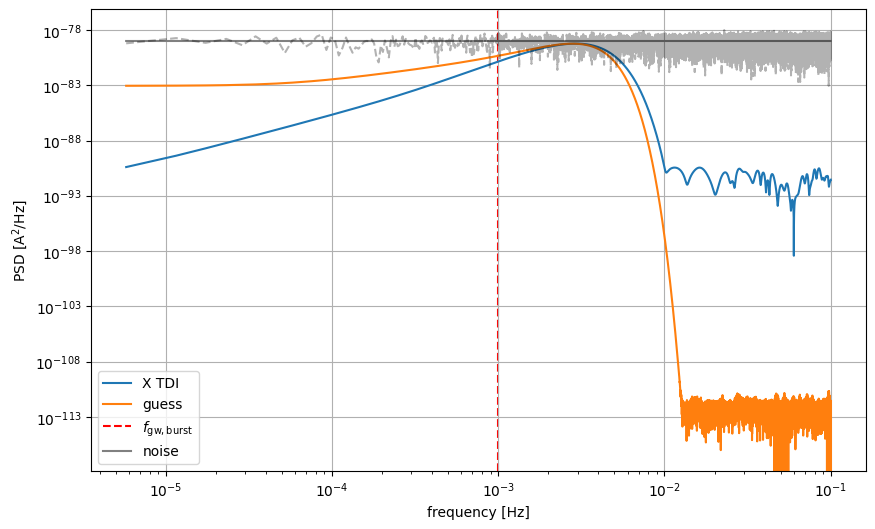

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.loglog(freqs_1s, discretePSD_1s(X_DFT_1s, times[start_trim:end_trim], norm=norm), label='X TDI')
ax.loglog(freqs_1s, discretePSD_1s(Xguess_DFT_1s, times[start_trim:end_trim], norm=norm), label='guess')

# ax.loglog(f_welch, Sx_welch, color='gray', linestyle='--', label = 'welch')
ax.axvline(f0, color='r', linestyle='--', label=r'$f_\mathrm{gw,burst}$', zorder=1)
# ax.axvline(f_cutoff, color='r', label='frequency cutoff')

ax.loglog(freqs_1s, S_noise, label='noise', color='gray')
ax.loglog(freqs_1s, discretePSD_1s(noise_DFT_1s, times[start_trim:end_trim], norm=norm), 'k--', alpha=0.3)


ax.set_ylabel(r'PSD $\left[\mathrm{A}^2 / \mathrm{Hz}\right]$'); ax.set_xlabel('frequency [Hz]')

ax.legend()
ax.grid()

# MCMC

In [34]:
def lnlike(vec, data, sigma_obs, times, scaling_vec=None):
    
    if scaling_vec:
        vec = np.asarray(vec) * np.asarray(scaling_vec)
        
    Model = SineGaussian(*vec, times)

    # Log-Likelihood (Gaussian)
    lnlikelihood = - (data - Model)**2 / (2*sigma_obs**2)

    return lnlikelihood.sum()

In [35]:
lnlike(injection[:-2], X_data, noise_sigma, times)

-3.088915338029342e+38

In [36]:
lnlike(glitch_guess, X_data, noise_sigma, times)

-47.92527768262759

In [37]:
lnlike(glitch_guess, glitch_guess_data, noise_sigma, times)

0.0

In [38]:
lnlike(glitch_guess, final_data, noise_sigma, times)

-17395.44545871046

In [39]:
print("Injection = ", injection[:-2])
print("Guess Glitch = ", glitch_guess)

Injection =  [1e-21, 0.001, 1.7, 100, 2114429462.0]
Guess Glitch =  [4e-40, 0.0028, 1.7, 140, 2114429150.0]


In [40]:
scale = [1e-40, 0.001, 1, 100, 1e9]
injection_scaled = (np.asarray(injection[:-2])/np.asarray(scale)).tolist()

glitch_guess_scaled = (np.asarray(glitch_guess)/np.asarray(scale)).tolist()

In [45]:
print("Injection rescaled = ", injection_scaled)
print("Glitch guess rescaled = ", glitch_guess_scaled)

Injection rescaled =  [1e+19, 1.0, 1.7, 1.0, 2.114429462]
Glitch guess rescaled =  [4.0, 2.8, 1.7, 1.4, 2.11442915]


In [41]:
# Set the prior distributions on each parameter
# REMEMBER: here we are searching over the 'rescaled' parameters (not the 'injection')

priors_in = {
             0: log_uniform(1e-41/scale[0], 1e-39/scale[0]),
             1: log_uniform(freqs_1s[0]/scale[1], freqs_1s[-1]/scale[1]),
             3: log_uniform(10/scale[3], 200/scale[3]),
             
             2: uniform_dist(0, 2*np.pi),
             4: uniform_dist(starttime/scale[-1], endtime/scale[-1]),
             # 4: uniform_dist( (t0-1000)/scale[-1], (t0+1000)/scale[-1]),
            }
priors = {"glitch": ProbDistContainer(priors_in)}

# Indicate which parameters are cyclic
periodic = {"glitch": {
                       2: 2*np.pi
                       },
           }
periodic = PeriodicContainer(periodic)

In [42]:
nwalkers    = 30
ntemps      = 8
ndim        = {"glitch": 5}
nleaves_min = {"glitch": 1}
nleaves_max = {"glitch": 1}

branch_names = ["glitch"]

# fill kwargs dictionary
tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf)

In [43]:
# Initialize the starting coordinates as a dictionary of arrays
coords = {"glitch": np.zeros((ntemps, nwalkers, nleaves_max["glitch"], ndim["glitch"]))}

# Initialize the inds as a dictionary of arrays
inds = {"glitch": np.zeros((ntemps, nwalkers, nleaves_max["glitch"]), dtype=bool)}  # np.zeros() used with dtype=bool sets the array values to "False" rather than 0

In [44]:
np.random.seed(42)

# So basically one population of walkers (for all temps) is generated in a tight ball in parameter space about the first injected signal for the first leaf,
#          another population of walkers (for all temps) is generated in a tight ball in parameter space about the second injected signal for the second leaf,
# and so on for every injected signal.
# But if we are allowing to search over more leaves than actual true injected signals, we will not actually initialize any walkers for those leaves!  They will
# spread out on their own to explore the potential for more leaves as the MCMC runs.
#
# This is the sigma for the multivariate Gaussian that sets starting points.
# We need it to be very small to assume we are passed the search phase.
# We will verify this with likelihood calculations.

# sig = 1e-3

nglitch = 1

for nn in range(nleaves_max["glitch"]):
    if nn >= nglitch:  # <-- If the number of leaves is greater than the number of injected signals
        # not going to add parameters for these unused leaves
        continue
    
    inds["glitch"][:, :, nn] = True

    coords["glitch"][:, :, nn] = priors["glitch"].rvs(size=(ntemps, nwalkers))

    # Here I am essentially initializing a ball of walkers around each of the injected glitches.  Each branch of the RJ contains a different ball!
    # coords["glitch"][:, :, nn] = np.random.multivariate_normal(injection_scaled[nn], np.diag(np.ones(ndim["glitch"])) * sig, size=(ntemps, nwalkers))


In [45]:
coords['glitch'].shape, coords['glitch'][0,1,0,:]

((8, 30, 1, 5),
 array([ 7.89366933, 63.78908232,  1.13872094,  0.77569527,  2.11450312]))

Parameter $f_0$ in chain Walker Initialization is not constrained
Parameter $\phi_0$ in chain Walker Initialization is not constrained
Parameter $\sigma_t$ in chain Walker Initialization is not constrained
Parameter $t_0$ in chain Walker Initialization is not constrained


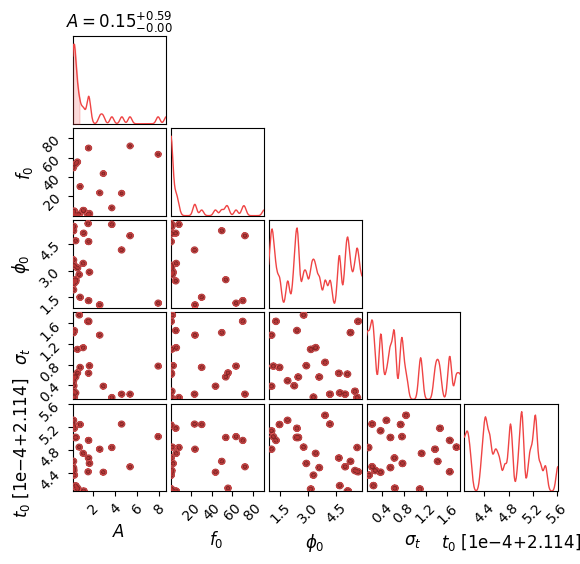

In [46]:
### Corner Plot
c = ChainConsumer()

labels = [r'$A$', r'$f_0$', r'$\phi_0$', r'$\sigma_t$', r'$t_0$']

pdsamples = pd.DataFrame(data    = coords["glitch"][0,:,:nglitch,:].reshape(-1,ndim["glitch"]), #* np.asarray(scale),
                         columns = labels)

# declare Chain object (you can do it within the .add_chain() method too)
chain = Chain(samples = pdsamples,
              columns = labels,
              name    = "Walker Initialization",
              color   = 'r',
              )

c.add_chain(chain)
# c.add_truth(Truth(location=dict(zip(labels, injection[:-2])), color='k'))

c.plotter.plot(figsize=(6,6));

In [47]:
# cov = {"glitch": np.diag(np.ones(ndim['glitch'])) * 0.001}

# moves    = [(GaussianMove(cov), 1), ]

# rj_moves = False

In [48]:
# Set number of iterations, burn-in, and thining parameters
nsteps  = 1000
burn    = 0
thin_by = 1

In [49]:
# Set up the backend for storing the results

!rm ./samples.h5

backend = HDFBackend('./samples.h5', name='glitch')

In [50]:
# Initialize sampler
ensemble = EnsembleSampler(nwalkers,
                           ndim,
                           lnlike,
                           priors,
                           # args = [X_data, noise_sigma, times, scale],
                           args = [final_data, noise_sigma, times, scale],
                           tempering_kwargs = tempering_kwargs,
                           periodic = periodic,                        
                           branch_names = branch_names,
                           nbranches = len(branch_names),
                           nleaves_min = nleaves_min,
                           nleaves_max = nleaves_max,
                           # moves = moves,
                           # rj_moves = rj_moves,
                           backend = backend,
                           )

In [51]:
prior_initialization      = ensemble.compute_log_prior(coords, inds=inds)
likelihood_initialization = ensemble.compute_log_like(coords, inds=inds, logp=prior_initialization)[0]


print("Any likelihood NaNs? --> ", np.isnan(likelihood_initialization).any())
print("Any prior NaNs?      --> ", np.isnan(prior_initialization).any())
print("Any likelihood infs? --> ", np.isinf(likelihood_initialization).any())
print("Any prior infs?      --> ", np.isinf(prior_initialization).any())

# which_temp = 0
# print(likelihood_initialization[which_temp,:])
# print(prior_initialization[which_temp,:])

Any likelihood NaNs? -->  False
Any prior NaNs?      -->  False
Any likelihood infs? -->  False
Any prior infs?      -->  False


In [52]:
# setup starting state
state = State(coords, inds=inds)

In [53]:
# RUN!
last_sample = ensemble.run_mcmc(state, nsteps, burn=burn, progress=True, thin_by=thin_by)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.25it/s]


In [54]:
# print('log-likelihood of the injection:           {0:0.2f}'.format(lnlike_FT(injection, freqs_1s, data_DFT_1s, noise_modelPSD_1s, dt, df, scaling_vec=None)))
print('Maximum log-likelihood value generated:    {0:0.2f}'.format(ensemble.get_log_like()[:,0,:].max()))
print('Maximum log-prior value generated:         {0:0.2f}'.format(ensemble.get_log_prior()[:,0,:].max()))
print('Maximum log-posterior value generated:     {0:0.2f}\n'.format(ensemble.get_log_posterior()[:,0,:].max()))
print('Jump acceptance fraction mean:             {0:0.4f}'.format(ensemble.acceptance_fraction[0,:].mean()))
print('Temperature swap acceptance fraction mean: {0:0.4f}'.format(ensemble.swap_acceptance_fraction.mean()))
# print('RJ acceptance fraction mean:               {0:0.4f}'.format(ensemble.rj_acceptance_fraction[0,:].mean()))

Maximum log-likelihood value generated:    -17355.69
Maximum log-prior value generated:         11.22
Maximum log-posterior value generated:     -17356.51

Jump acceptance fraction mean:             0.1368
Temperature swap acceptance fraction mean: 0.7746


In [69]:
# If you don't need to reload the backend because you just ran it, then....
ensemble.run_mcmc(None, nsteps=5000, burn=0, progress=True, thin_by=thin_by)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:18<00:00, 11.41it/s]


In [70]:
# print('log-likelihood of the injection:           {0:0.2f}'.format(lnlike_FT(injection, freqs_1s, data_DFT_1s, noise_modelPSD_1s, dt, df, scaling_vec=None)))
print('Maximum log-likelihood value generated:    {0:0.2f}'.format(ensemble.get_log_like()[:,0,:].max()))
print('Maximum log-prior value generated:         {0:0.2f}'.format(ensemble.get_log_prior()[:,0,:].max()))
print('Maximum log-posterior value generated:     {0:0.2f}\n'.format(ensemble.get_log_posterior()[:,0,:].max()))
print('Jump acceptance fraction mean:             {0:0.4f}'.format(ensemble.acceptance_fraction[0,:].mean()))
print('Temperature swap acceptance fraction mean: {0:0.4f}'.format(ensemble.swap_acceptance_fraction.mean()))
# print('RJ acceptance fraction mean:               {0:0.4f}'.format(ensemble.rj_acceptance_fraction[0,:].mean()))

Maximum log-likelihood value generated:    -17355.36
Maximum log-prior value generated:         11.32
Maximum log-posterior value generated:     -17356.21

Jump acceptance fraction mean:             0.4638
Temperature swap acceptance fraction mean: 0.6794


In [71]:
# Load from memory
# loaded_data = ensemble

# Load from the backend
loaded_data = HDFBackend('./samples.h5', name='glitch')
# loaded_data = backend

In [72]:
# Find the indices (iteration,walker) for the T=0 chain where the log-likelihood is maximum...
ind_maxlike_it, ind_maxlike_walk = np.where(loaded_data.get_log_like()[:,0,:] == loaded_data.get_log_like()[:,0,:].max())

# ...then store the max-likelihood parameters
maxlike_params = loaded_data.get_chain()['glitch'][int(ind_maxlike_it[0]), 0, int(ind_maxlike_walk[0]), :, :]

print("Maximum log-likelihood parameters (scaled) = ", maxlike_params)
print("Maximum log-likelihood parameters          = ", maxlike_params * scale)
print("Double check: retrieved max log-likelihood       = {0:0.2f}".format(loaded_data.get_log_like()[:,0,:].max()))
print("              log-likelihood at max param values = {0:0.2f}".format(lnlike(*maxlike_params, final_data, noise_sigma, times, scaling_vec=scale)))


Maximum log-likelihood parameters (scaled) =  [[3.54461892 3.02930325 1.48426047 1.51910779 2.11442912]]
Maximum log-likelihood parameters          =  [[3.54461892e-40 3.02930325e-03 1.48426047e+00 1.51910779e+02
  2.11442912e+09]]
Double check: retrieved max log-likelihood       = -17355.36
              log-likelihood at max param values = -17355.36


In [73]:
# Grab the array of temperatures throughout the MCMC
temperatures = 1 / loaded_data.get_betas()

/var/folders/2r/8_zh1dcs4xq16xqb_37cz9d80000gp/T/ipykernel_51546/3532003290.py:2: RuntimeWarning: divide by zero encountered in divide
  temperatures = 1 / loaded_data.get_betas()


In [74]:
# Choose discrete, evenly-spaced color values spanning the full colormap range
# -> warm color to hot temps
# -> cool color to cold temps
cm_temp      = plt.cm.get_cmap('plasma')
cm_temp_list = [cm_temp(i) for i in range(cm_temp.N)]
cm_temp_list = cm_temp_list[::cm_temp.N//ntemps]

/var/folders/2r/8_zh1dcs4xq16xqb_37cz9d80000gp/T/ipykernel_51546/1665350800.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_temp      = plt.cm.get_cmap('plasma')


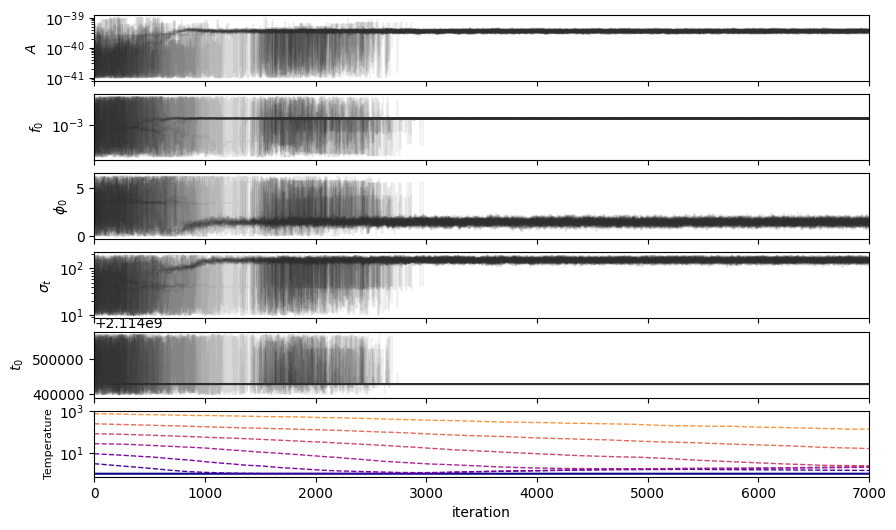

In [75]:
### Chain Plot
fig, ax = plt.subplots(ndim['glitch']+1, 1, sharex=True)
fig.set_size_inches(10, 6)

# Specify the index of which temperature to plot
which_temp = 0

params = [r'$A$', r'$f_0$', r'$\phi_0$', r'$\sigma_t$', r'$t_0$']

# Indicate which dimensions should have log-axes
log_dims = [0,1,None,3,None]

for i in range(ndim['glitch']):
    ax[i].set_ylabel(params[i])

    # Overlay all of the walkers for each parameter
    for walk in range(nwalkers):
        if i == log_dims[i]:
            ax[i].semilogy(ensemble.get_chain()['glitch'][:, which_temp, walk, :, i] * scale[i], color='k', alpha=0.05)
        else:
            ax[i].plot(ensemble.get_chain()['glitch'][:, which_temp, walk, :, i] * scale[i], color='k', alpha=0.05)
    
# for i in range(ndim['glitch']):
#     ax[i].axhline(injection[i], color='C{0}'.format(j), linestyle='--')
ax[-1].set_xlabel("iteration");

# In the final row, plot the temperatures as they evolve over the MCMC
for i in range(ntemps):
    # For the chosen temperature, make it bold
    if i == which_temp:
        ax[-1].semilogy(temperatures[:,i], color=cm_temp_list[i])
    else:
        ax[-1].semilogy(temperatures[:,i], color=cm_temp_list[i], linewidth=1, linestyle='--')
ax[-1].set_ylabel('Temperature', fontsize=8);
ax[-1].set_xlim([0, len(temperatures)]);

In [89]:
burn = 4000
thin = 1

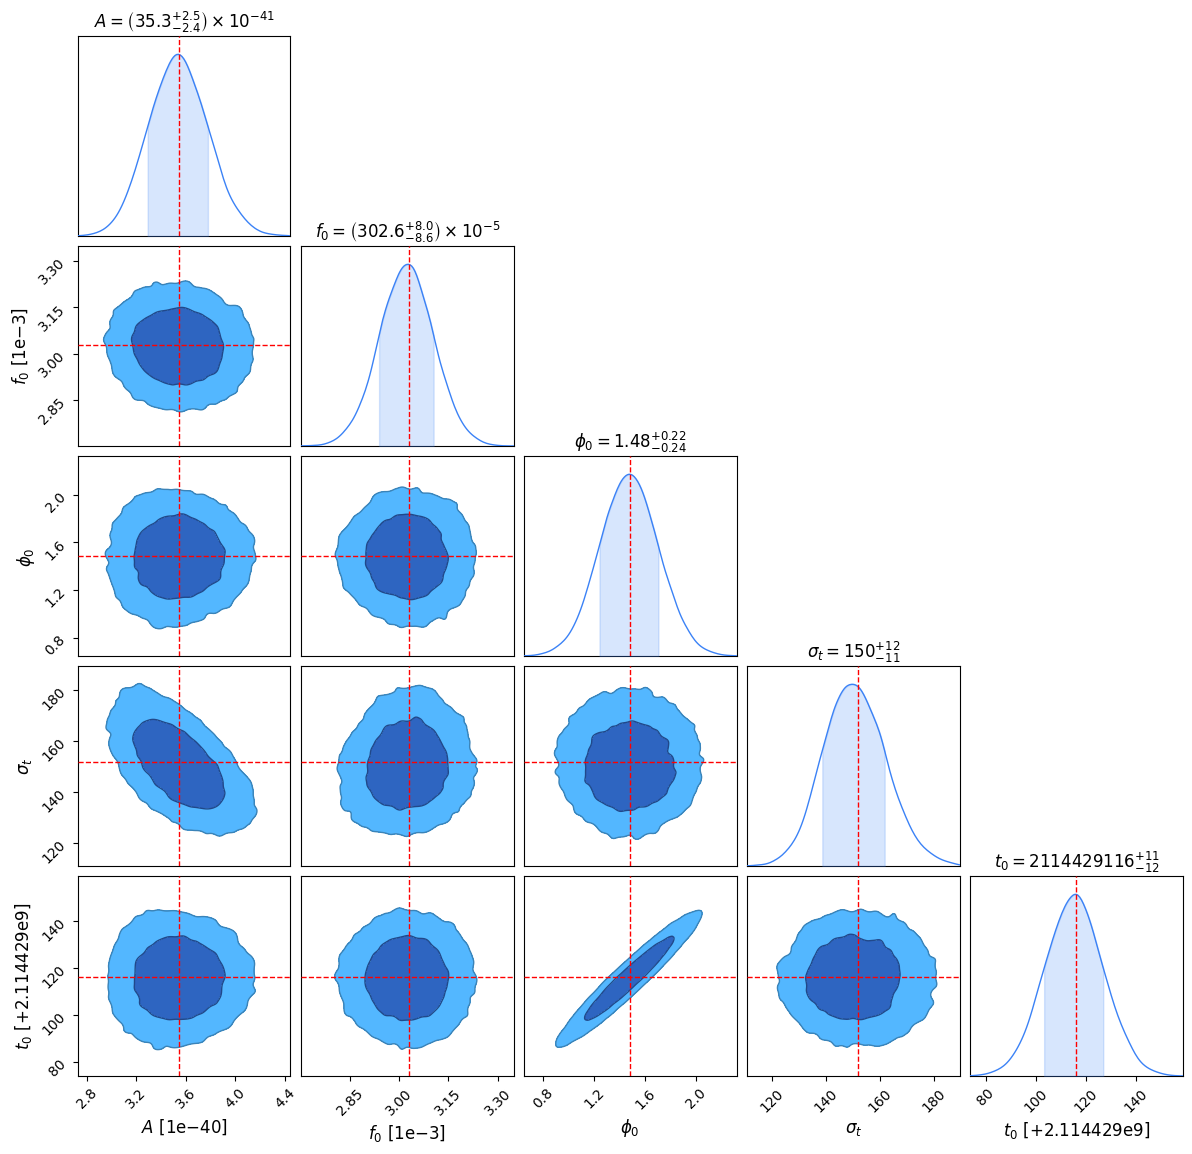

In [90]:
### Corner Plot (T=0)
c = ChainConsumer()

labels = [r'$A$', r'$f_0$', r'$\phi_0$', r'$\sigma_t$', r'$t_0$']#, r'$\mathrm{log}\mathcal{L}$']

which_temp = 0
samples = loaded_data.get_chain()['glitch'][burn::thin, 0, :, :, :].reshape(-1, ndim['glitch']) * np.asarray(scale) # <-- Don't forget to scale the samples back!

# NOTE: the '~' operator seems to take the reverse boolean of an array (so ~np.array([True, False]) = np.array([False, True])
#       So ~np.isnan(samples[:,0]) returns an boolean array - 'True' when there is an actual number at the indexed value, and 'False' if there is a nan at the indexed value
#       Therefore samples[~np.isnan(samples[:,0])] returns an array with all of the nan's excised!
samples = samples[~np.isnan(samples[:, 0])]

# In the new ChainConsumer (1.0+), one needs to convert samples into Pandas DataFrames
pdsamples = pd.DataFrame(data    = samples,
                         columns = labels)
# declare Chain object (you can do it within the .add_chain() method too)
chain = Chain(samples = pdsamples,
              columns = labels,
              name    = 'RJ ({0} model max)'.format(nleaves_max['glitch']),
              )

c.add_chain(chain)

# for inj in injection:
# c.add_truth(Truth(location=dict(zip(labels, glitch_guess)), color='r'))
# for maxlike in maxlike_params:
c.add_truth(Truth(location=dict(zip(labels, *maxlike_params*scale)), color='r'))

c.plotter.plot();

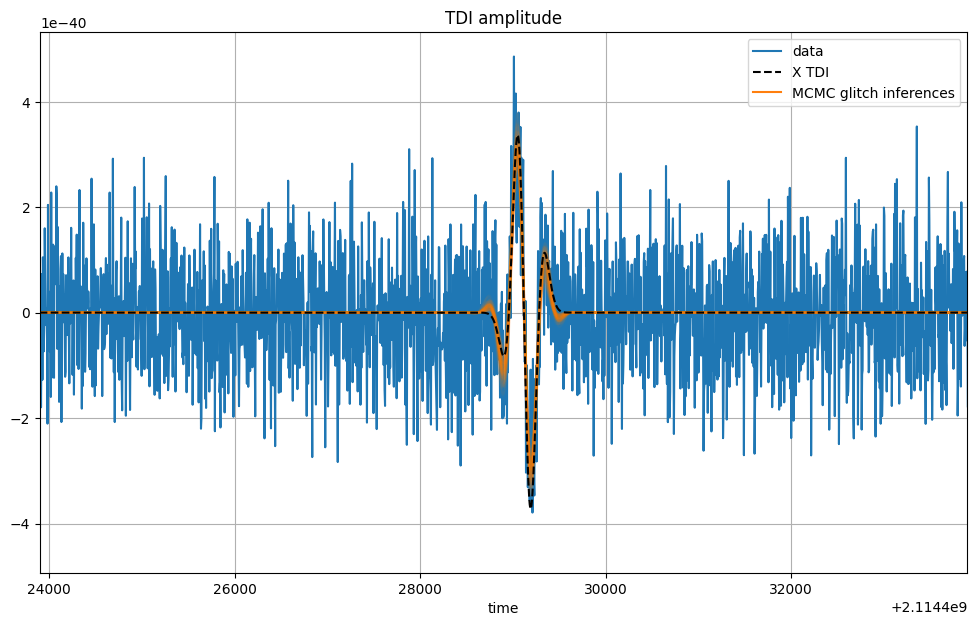

In [91]:
### Recovered Waveform + Residual Inferences
fig, ax = plt.subplots(1,1, figsize=(10,6), sharex=True)
fig.tight_layout()

which_temp = 0

ax.plot(times, final_data, label='data')

# Store the samples with branch information
samples = loaded_data.get_chain()['glitch'][burn::thin, which_temp].reshape(-1, nleaves_max['glitch'], ndim['glitch']) * np.asarray(scale) # <-- Don't forget to scale the samples back!

# Let's plot a random selection of some of our samples over the data and true signal
inds = np.random.randint(len(samples), size=100)
for ind in inds:
    ax.plot(times, SineGaussian(*samples[ind,0,:], times), 'C1', alpha=0.05)

ax.plot(times, X_data, 'k--', label='X TDI')

# manually add 'MCMC fits' line to legend
handles1, labels1 = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='MCMC glitch inferences', color='C1')
handles1.extend([line1])

ax.legend(handles=handles1, loc='upper right')
ax.grid()

ax.set_xlim([starttime+25000, starttime+35000])
ax.set_xlabel("time")
ax.set_title("TDI amplitude")
plt.show()
# plt.savefig("../figures/eryn_3channel_sampler/1_priorstart_gibbs_inference.png", bbox_inches='tight', dpi=300);

In [98]:
injection

[1e-21, 0.001, 1.7, 100, 2114429462.0, 0, 0.7853981633974483]

In [99]:
maxlike_params*scale

array([[3.54461892e-40, 3.02930325e-03, 1.48426047e+00, 1.51910779e+02,
        2.11442912e+09]])

In [102]:
for i in range(0,5):
    print(f"parameter {i}: {injection[i]}, {(maxlike_params*scale)[0][i]}")

parameter 0: 1e-21, 3.5446189186394e-40
parameter 1: 0.001, 0.0030293032537057093
parameter 2: 1.7, 1.4842604656184648
parameter 3: 100, 151.9107785755609
parameter 4: 2114429462.0, 2114429116.0530005
